# Convolutional GPROF rain rate retrieval

This notebook demonstrates how convolutional neural networks (CNNs) can be used as backbone of a QRNN for the retrieval of rain fall rates from passive microwave observations. The use of CNNs and how these can be used to make exploit structural information

## Running this notebook in Colab

This notebook will make use of comparably complex networks, so it is recommended to run the training on a GPU to keep the required time at a reasonable level. If system you are working on doesn't have a GPU, you can run this notebook on Google Colab by clicking on the badge below.

<a href="https://colab.research.google.com/github/simonpf/quantnn/blob/master/notebooks/convolutional_rain_rate_retrieval.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" align="left" style="padding: 20px 0 0 0;"/>
</a>



> **Note:** To run this notebook on Google Colab you will need to uncomment and execute the two commands in the code cell below. 

In [1]:
! pip install --upgrade git+https://github.com/simonpf/quantnn/
! pip install torch

  Cloning https://github.com/simonpf/quantnn/ to /tmp/pip-req-build-jxw_t2j6
  Running command git clone -q https://github.com/simonpf/quantnn/ /tmp/pip-req-build-jxw_t2j6
  Created wheel for quantnn: filename=quantnn-0.0.1.dev0-cp37-none-any.whl size=70051 sha256=286aa793cf78af74e2e34038989277c0166b88cd6bee6158bf7cea6c4dc4e6c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-ev5wfk1w/wheels/7b/71/a4/59b0f5ed7a5e621bd3b4cc6ebb56b49986f1276af112c52b55
Successfully built quantnn
  Found existing installation: quantnn 0.0.1.dev0
    Uninstalling quantnn-0.0.1.dev0:
      Successfully uninstalled quantnn-0.0.1.dev0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from quantnn.plotting import set_style
set_style()

## The Data

The training and validation data that we will be working with in this example comes from the Core Observatory (CO) of the [Global Precipitation Measurement](https://en.wikipedia.org/wiki/Global_Precipitation_Measurement) (GPM) mission. 

### Input data

The input data consists of pseudo images of multi-spectral microwave observations from the [GPM Microwave Imager (GMI)](https://gpm.nasa.gov/missions/GPM/GMI). Each pixel in these images comprises 13 measurements at different microwave frequencies. The vertical axis of the images is oriented along the the track of the satellite.

Since GMI performs conical scans and due to the ellyptical shape of the Earth, the pixels of an image don't map to a rectilinear geometry on the Earth's surface. Instead, pixels at the edges of the swath, i.e. the horizontal edges of the images, are translated backwards (or forwards, when GMI is looking backwards) and features are enlarged due to the pixel footprints being located closer together.








### Output data

The aim of this example is to use the GMI observations and predict the amount of precipitation on the ground.
The data that we will use to train the network also comes from the GPM CO satellite, which carries a precipitation radar in addition to GMI. By combining the observations from the radar and GMI, the percipitation can be determined very accurately. The radar, however, has a much narrower swath than GMI, so these highly accurate retrievals are limited to a narrow stripe center of the GMI swath.  Moreover, the training data has been extended with data from [Microwave Integrated Retrieval System (MiRS)](https://ieeexplore.ieee.org/abstract/document/9109712) in locations where the radar may have missed light precipitation.

In [3]:
from quantnn.examples.gprof_conv import download_data
download_data()

In [4]:
data = np.load("data/gprof_conv.npz")
x_train = data["x_train"]
y_train = data["y_train"]
x_val = data["x_val"]
y_val = data["y_val"]

The cell below displays random input images from the training input and output data. Panel (a) and (b) show the GMI observations at the channels with the lowest and highest frequency, respectively. 

Since the images show the world from above at frequencies that we are not used to see, it can be hard to make sense of the scenes. I helps to know though, that the lowest frquency channel can see the Earth surface and that water surfaces are typically cold (low values), whereas land surface are warm (high values). Over a cold, i.e. dark, background, strong rain appeare as a signal at these frequencies.

The high-frequency channel (Panel (b)) generally can't see down to the surface and the warm background which typically dominates the images comes from the water vapor in the troposphere. Thick, high clouds which contain snow appear as dark stains on this bright background. In some of the images of the high-frequency channels the observations at the image borders are missing. This is because at the edges of the GMI swath the high-frequency observations aren't available, so the training data has been augmented with these observations.

Panel (c) shows the reference rain rate at the center of the GMI swath where combined passive-only/radar observations are available. Where they aren't the reference data is set to the value -1.

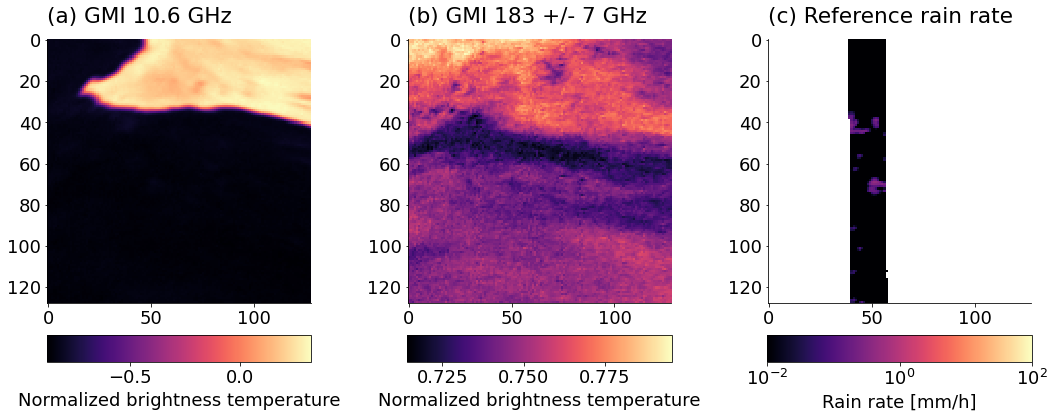

In [5]:
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec

f = plt.figure(figsize=(15, 6))
gs =  GridSpec(2, 3, figure=f, height_ratios=[1.0, 0.1])
index = np.random.randint(x_train.shape[0])

precip_norm = LogNorm(1e-2, 1e2)

ax = plt.subplot(gs[0, 0])
m = ax.imshow(x_train[index, 0, :, :])
ax.grid(False)
ax.set_title("(a) GMI 10.6 GHz", loc="left")
ax = plt.subplot(gs[1, 0])
plt.colorbar(m, cax=ax, orientation="horizontal", label="Normalized brightness temperature")

ax = plt.subplot(gs[0, 1])
m = ax.imshow(x_train[index, -1, :, :])
ax.grid(False)
ax.set_title("(b) GMI 183 +/- 7 GHz", loc="left")
ax = plt.subplot(gs[1, 1])
plt.colorbar(m, cax=ax, orientation="horizontal", label="Normalized brightness temperature")

ax = plt.subplot(gs[0, 2])
m = ax.imshow(y_train[index, :, :], norm=precip_norm)
ax.grid(False)
ax.set_title("(c) Reference rain rate", loc="left")
ax = plt.subplot(gs[1, 2])
plt.colorbar(m, cax=ax, orientation="horizontal", label=r"Rain rate [mm/h]")

plt.tight_layout()

## Training a baseline model

We start by training a very simple baseline model. We use a fully-connected network which uses only the information from a single pixel to perform the rain rate retrieval. In order to avoid having to modify the training data, we will implement the fully-connected model using a
convolutional network, which uses only $1\times1$ convolution layers. Since we can only use the training data at the center of the images, this will of course be quite inefficient but for this simple example this should be acceptable.

The network we choose here has three layers with 128 neuron in the hidden layers and ReLU activation functions following the inner layers of the network. The network also includes batch normalization layers, which are typically used in deeper convolutional networks, but may not be required here.

In [6]:
import torch
from torch import nn
from quantnn.qrnn import QRNN

quantiles = np.linspace(0.01, 0.99, 99)

model_fc = nn.Sequential(
    nn.Conv2d(13, 128, 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, 128, 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(128, quantiles.size, 1)
)

qrnn_fc = QRNN(quantiles=quantiles, model=model_fc)

We adopt a cosine annealing learning rate schedule with one restart to train the model.

> **Note:** Since training data is available only in some regions of the input, the training uses the ``mask`` keyword argument to tell the training routine how to identify training samples that should be ignored.

In [7]:
from quantnn.models.pytorch import BatchedDataset
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR

training_data = BatchedDataset((x_train, y_train), 32)
validation_data = BatchedDataset((x_val, y_val), 32)
n_epochs = 20
optimizer = SGD(model_fc.parameters(), lr=0.1, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, n_epochs, 0.001)
qrnn_fc.train(training_data=training_data,
              validation_data=validation_data,
              n_epochs=n_epochs,
              optimizer=optimizer,
              scheduler=scheduler,
              mask=-1,
              device="gpu");
scheduler = CosineAnnealingLR(optimizer, n_epochs, 0.0001)
qrnn_fc.train(training_data=training_data,
              validation_data=validation_data,
              n_epochs=n_epochs,
              optimizer=optimizer,
              scheduler=scheduler,
              mask=-1,
              device="gpu");

Epoch  1 / 20: train. loss = 0.0959, val. loss = 0.0510, lr. = 0.1000, time = 2.747835 s
Epoch  2 / 20: train. loss = 0.0550, val. loss = 0.0395, lr. = 0.0994, time = 2.727775 s
Epoch  3 / 20: train. loss = 0.0450, val. loss = 0.0347, lr. = 0.0976, time = 2.728911 s
Epoch  4 / 20: train. loss = 0.0422, val. loss = 0.0322, lr. = 0.0946, time = 2.727945 s
Epoch  5 / 20: train. loss = 0.0402, val. loss = 0.0381, lr. = 0.0905, time = 2.735553 s
Epoch  6 / 20: train. loss = 0.0395, val. loss = 0.0254, lr. = 0.0855, time = 2.732466 s
Epoch  7 / 20: train. loss = 0.0382, val. loss = 0.0301, lr. = 0.0796, time = 2.734751 s
Epoch  8 / 20: train. loss = 0.0380, val. loss = 0.0311, lr. = 0.0730, time = 2.736213 s
Epoch  9 / 20: train. loss = 0.0363, val. loss = 0.0267, lr. = 0.0658, time = 2.729781 s
Epoch 10 / 20: train. loss = 0.0368, val. loss = 0.0317, lr. = 0.0582, time = 2.731628 s
Epoch 11 / 20: train. loss = 0.0364, val. loss = 0.0296, lr. = 0.0505, time = 2.728587 s
Epoch 12 / 20: train.

## Training a convolutional QRNN

To find out whether we can improve on the performance of the fully-connected model, we will train a fully-concolutional network to perform perform dense predictions of the surface rain rate.

The network employed here has an [asymetric encoder-decoder architecture](https://arxiv.org/abs/1612.03144) with five down- and upsampling stages. Each stage uses 2 [Xception blocks](https://arxiv.org/abs/1610.02357), with 128 feature channels each. This has the advantage that the model has a much lower memory footprint than it would have with a symmetric encoder-decoder architecture and full convolution layers. 

In [10]:
from quantnn.models.pytorch.xception import XceptionFpn
from quantnn.qrnn import QRNN
model_c = XceptionFpn(13, quantiles.size, n_features=128)
qrnn_c = QRNN(quantiles=quantiles, model=model_c)

In [11]:
from quantnn.models.keras import CosineAnnealing

training_data = BatchedDataset((x_train, y_train), 8)
validation_data = BatchedDataset((x_val, y_val), 8)
n_epochs = 20
optimizer = SGD(model_c.parameters(), lr=0.1, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, n_epochs, 0.001)
qrnn_c.train(training_data=training_data,
              validation_data=validation_data,
              n_epochs=n_epochs,
              optimizer=optimizer,
              scheduler=scheduler,
              mask=-1,
              device="gpu");
scheduler = CosineAnnealingLR(optimizer, n_epochs, 0.0001)
qrnn_c.train(training_data=training_data,
              validation_data=validation_data,
              n_epochs=n_epochs,
              optimizer=optimizer,
              scheduler=scheduler,
              mask=-1,
              device="gpu");

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Epoch  1 / 20: train. loss = 0.0692, val. loss = 0.0479, lr. = 0.1000, time = 13.154228 s
Epoch  2 / 20: train. loss = 0.0531, val. loss = 0.0377, lr. = 0.0994, time = 13.159344 s
Epoch  3 / 20: train. loss = 0.0455, val. loss = 0.0323, lr. = 0.0976, time = 13.172379 s
Epoch  4 / 20: train. loss = 0.0417, val. loss = 0.0381, lr. = 0.0946, time = 13.17994 s
Epoch  5 / 20: train. loss = 0.0402, val. loss = 0.0313, lr. = 0.0905, time = 13.205461 s
Epoch  6 / 20: train. loss = 0.0388, val. loss = 0.0353, lr. = 0.0855, time = 13.186765 s
Epoch  7 / 20: train. loss = 0.0364, val. loss = 0.0293, lr. = 0.0796, time = 13.191693 s
Epoch  8 / 20: train. loss = 0.0350, val. loss = 0.0281, lr. = 0.0730, time = 13.170589 s
Epoch  9 / 20: train. loss = 0.0348, val. loss = 0.0317, lr. = 0.0658, time = 13.199547 s
Epoch 10 / 20: train. loss = 0.0332, val. loss = 0.0340, lr. = 0.0582, time = 13.175529 s
Epoch 11 / 20: train. loss = 0.0341, val. loss = 0.0263, lr. = 0.0505, time = 13.174661 s
Epoch 12 / 

## Evaluating the models

To evaluate the two models, we will compare the predicted mean precipitation values to the reference value, where this data is available.

In [18]:
torch.cuda.empty_cache()
validation_data = BatchedDataset((x_val, y_val), 5)

y_true = []
y_pred_fc = []
y_pred_c = []
for x, y in validation_data:
  y_true += [y.detach().numpy()]
  y_pred_fc += [qrnn_fc.posterior_mean(x=x).cpu().detach().numpy()]
  y_pred_c += [qrnn_c.posterior_mean(x=x).cpu().detach().numpy()]
y_true = np.concatenate(y_true, axis=0)
y_pred_fc = np.concatenate(y_pred_fc, axis=0)
y_pred_c = np.concatenate(y_pred_c, axis=0)

/usr/local/lib/python3.7/dist-packages/quantnn/generic.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return module.tensor(array, dtype=like.dtype, device=like.device)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [19]:
bins = np.logspace(-2, 2, 41)
indices = y_true >= 0.0
freqs_fc, _, _ = np.histogram2d(y_true[indices], y_pred_fc[indices], bins=bins)
freqs_c, _, _ = np.histogram2d(y_true[indices], y_pred_c[indices], bins=bins)

The scatter plots shown below indicate a fairly clear improvement of the convolutional network compared to the fully-connected network.

> **Note:** Both trainings in this example have been comparatively short, so that is likely that the performance of both networks could be improved further by continuing the training and decreasing the mimimum learning rate.

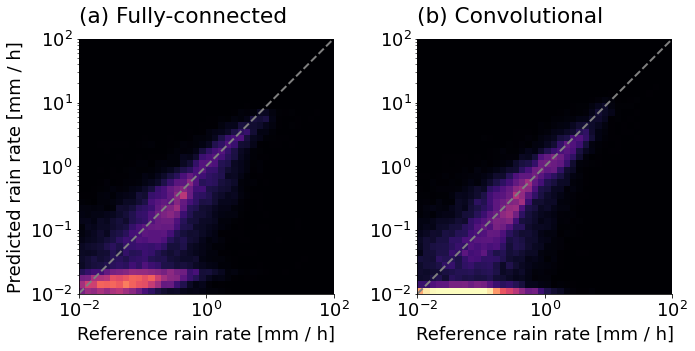

In [35]:
from matplotlib.colors import Normalize
norm = Normalize(0, 400)
indices = y_val >= 0.0


f, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
ax.pcolormesh(bins, bins, freqs_fc.T, norm=norm)
ax.set_xlim([1e-2, 1e2])
ax.set_ylim([1e-2, 1e2])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Reference rain rate [mm / h]")
ax.set_ylabel("Predicted rain rate [mm / h]")
ax.set_title("(a) Fully-connected", loc="left")
ax.plot(bins, bins, c="grey", ls="--")
ax.set_aspect(1.0)

ax = axs[1]
m = ax.pcolormesh(bins, bins, freqs_c.T, norm=norm)
ax.set_xlim([1e-2, 1e2])
ax.set_ylim([1e-2, 1e2])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Reference rain rate [mm / h]")
ax.set_title("(b) Convolutional", loc="left")
ax.plot(bins, bins, c="grey", ls="--")
ax.set_aspect(1.0)

plt.tight_layout()

Finally, let's look at some example predictions. The plot below show some of the input channels together with the reference precipitation and the prediction from both models.

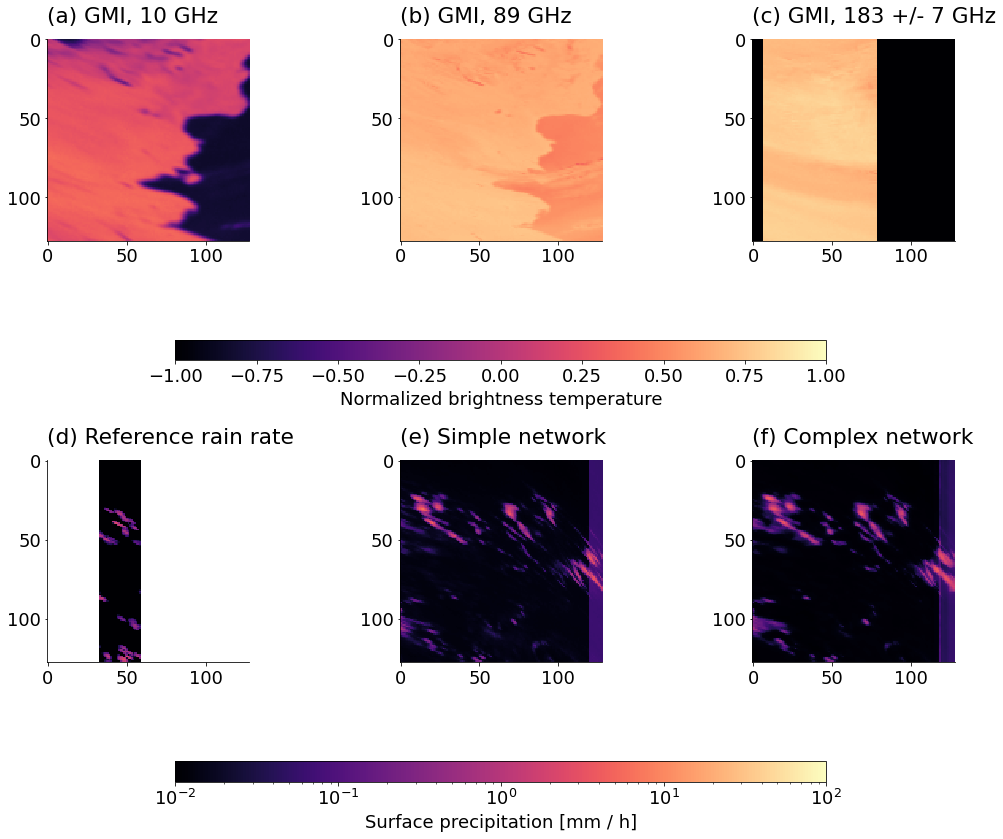

In [56]:
from matplotlib.colors import LogNorm, Normalize
from matplotlib.gridspec import GridSpec

f = plt.figure(figsize=(15, 12))
gs =  GridSpec(4, 6, figure=f, height_ratios=[1.0, 0.1, 1.0, 0.1])
bt_norm = Normalize(-1, 1)

index = np.random.randint(x_val.shape[0])

precip_norm = LogNorm(1e-2, 1e2)

ax = plt.subplot(gs[0, 0:2])
m = ax.imshow(x_val[index, 0, :, :], norm=bt_norm)
ax.grid(False)
ax.set_title("(a) GMI, 10 GHz", loc="left")
ax = plt.subplot(gs[1, 1:5])
plt.colorbar(m, cax=ax, orientation="horizontal", label="Normalized brightness temperature")

ax = plt.subplot(gs[0, 2:4])
m = ax.imshow(x_val[index, 7, :, :], norm=bt_norm)
ax.grid(False)
ax.set_title("(b) GMI, 89 GHz", loc="left")
    
ax = plt.subplot(gs[0, 4:])
m = ax.imshow(x_val[index, -1, :, :], norm=bt_norm)
ax.grid(False)
ax.set_title("(c) GMI, 183 +/- 7 GHz", loc="left")

ax = plt.subplot(gs[2, 0:2])
m = ax.imshow(y_true[index, :, :], norm=precip_norm)
ax.grid(False)
ax.set_title("(d) Reference rain rate", loc="left")
ax = plt.subplot(gs[3, 1:5])
plt.colorbar(m, cax=ax, orientation="horizontal", label="Surface precipitation [mm / h]")

ax = plt.subplot(gs[2, 2:4])
ax.imshow(y_pred_fc[index, :, :], norm=precip_norm)
ax.grid(False)
ax.set_title("(e) Simple network", loc="left")
    
ax = plt.subplot(gs[2, 4:])
ax.imshow(y_pred_c[index, :, :], norm=precip_norm)
ax.grid(False)
ax.set_title("(f) Complex network", loc="left")

plt.tight_layout()